In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
from IPython.core.display import display

In [2]:
df_raw = pd.read_pickle('../testData/scrobbles_processed/5759068.pkl')

In [792]:
features = np.load('../GenreModeling/data/features/lda_artists/features_190.npy')
n_features = features.shape[1]
features = {i:features[i] for i in xrange(len(features))}

def get_features(idx):
    return features.get(idx,np.repeat(np.nan,n_features))

def calc_dist(idx_1,idx_2):
    features1 = get_features(idx_1)
    features2 = get_features(idx_2)
    if np.any(np.isnan(features1)) or np.any(np.isnan(features2)):
        return np.nan
    if np.all(features1==features2):
        return 0.0
    return cosine(features1,features2)

artist_pops = pd.Series([line.split(',')[1] for line in open('../GenreModeling/data/artist_pop')],dtype=float)
total_users = 145148.
idf = pd.Series(np.log(total_users / np.loadtxt('../testData/idf_data',dtype=float)))
idf.name='idf'


# Artist basis

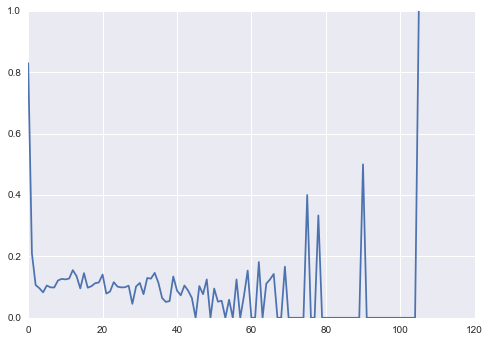

In [31]:
blocks = pd.read_pickle('../testData/scrobbles_processed/5759068.pkl')['block']
result = blocks.value_counts().value_counts()
arr = result.reindex(xrange(1,max(result.index)+1),fill_value=0.).values
final_result = arr/(np.cumsum(arr[::-1])[::-1])
plt.plot(final_result)

In [794]:
# copy to generate random shuffle version
df_raw_rand = df_raw.copy()
idx = np.array(df_raw_rand.index)
np.random.shuffle(idx)
df_raw_rand = df_raw_rand.reindex(idx).reset_index(drop=True)

In [795]:
df_raw['nextdist'] = df_raw['dist'].shift(-1)
df_raw_rand['next'] = df_raw_rand['artist_idx'].shift(-1)
df_raw_rand['nextdist'] = df_raw_rand.apply(lambda row: calc_dist(row['artist_idx'],row['next']),axis=1)

blocked = df_raw.groupby('block').apply(lambda x: x.iloc[-1])
blocked['n'] = df_raw.groupby('block')['ts'].count()
blocked_rand = blocked.copy()
idx = np.array(blocked_rand.index)
np.random.shuffle(idx)
blocked_rand = blocked_rand.reindex(idx).reset_index(drop=True)

blocked_rand['next'] = blocked_rand['artist_idx'].shift(-1)
blocked_rand['nextdist'] = blocked_rand.apply(lambda row: calc_dist(row['artist_idx'],row['next']),axis=1)





In [797]:
# def 2: up-to-moment prop. listens
def calc_c_counts(df):
    df['index'] = range(1,len(df)+1)
    return df[['index']]
def calc_c_blockcounts(df):
    df['index'] = df['n'].cumsum()
    return df[['index']]


indices = df_raw.groupby('artist_idx').apply(calc_c_counts)
df_raw['index'] = indices
df_raw['overall_index'] = df_raw.index + 1
df_raw['current_value'] = df_raw['index'] / df_raw['overall_index']

df_raw_rand = df_raw_rand.groupby('artist_idx').apply(calc_c_counts)
df_raw_rand['overall_index'] = df_raw_rand.index + 1
df_raw_rand['current_value'] = df_raw_rand['index'] / df_raw_rand['overall_index']

indices = blocked.groupby('artist_idx').apply(calc_c_blockcounts)
blocked['index'] = indices
blocked['overall_index'] = blocked['n'].cumsum()
blocked['current_value'] = blocked['index'] / blocked['overall_index']

indices = df_raw_rand.groupby('artist_idx').apply(calc_c_counts)
df_raw_rand['index'] = indicesblocked_rand['index'] = indices
blocked_rand['overall_index'] = blocked_rand['n'].cumsum()
blocked_rand['current_value'] = blocked_rand['index'] / blocked_rand['overall_index']

In [798]:
# def 5: tf-idf variant of up-to-moment prop. listens
df_raw['current_value_tfidf'] = df_raw['current_value'] * df_raw['idf']
df_raw_rand['current_value_tfidf'] = df_raw_rand['current_value'] * df_raw_rand['idf']

blocked['current_value_tfidf'] = blocked['current_value'] * blocked['idf']
blocked_rand['current_value_tfidf'] = blocked_rand['current_value'] * blocked_rand['idf']

In [883]:
def return_time(df):
    df['return_time'] = df['overall_index'].shift(-1) - df['overall_index']-1
    return df[['return_time']]

rt = df_raw.groupby('artist_idx').apply(return_time)
df_raw['return_time'] = rt

rt = df_raw_rand.groupby('artist_idx').apply(return_time)
df_raw_rand['return_time'] = rt

rt = blocked.groupby('artist_idx').apply(return_time)
blocked['return_time'] = rt

rt = blocked_rand.groupby('artist_idx').apply(return_time)
blocked_rand['return_time'] = rt

In [886]:
df_raw.iloc[3016:3036]

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,nextdist,index,overall_index,current_value,current_value_tfidf,return_time
3016,0.949231,1351.0,2007-08-12 23:15:26,0.0,162.0,1822.0,1745.0,0.002414,1.244477e-04,1.649808,0.003982,0.829781,15.0,3017,0.004972,0.008203,66.0
3017,0.829781,71.0,2007-08-12 23:18:54,0.0,162.0,1823.0,1746.0,0.010742,1.151145e-03,0.969258,0.010412,0.936956,103.0,3018,0.034129,0.033079,48.0
3018,0.936956,177.0,2007-08-12 23:21:03,0.0,162.0,1824.0,1747.0,0.000646,6.589665e-04,1.574425,0.001017,0.835480,5.0,3019,0.001656,0.002608,294.0
3019,0.835480,6.0,2007-08-12 23:25:47,0.0,162.0,1825.0,1748.0,0.005303,2.689476e-03,0.490017,0.002599,0.542428,20.0,3020,0.006623,0.003245,28.0
3020,0.542428,86.0,2007-08-12 23:29:05,0.0,162.0,1826.0,1749.0,0.003331,1.064879e-03,0.732034,0.002439,0.776773,42.0,3021,0.013903,0.010177,44.0
3021,0.776773,3013.0,2007-08-12 23:36:26,0.0,162.0,1827.0,1750.0,0.001037,5.295473e-05,2.073808,0.002150,0.751398,1.0,3022,0.000331,0.000686,95.0
3022,0.751398,6486.0,2007-08-12 23:40:00,0.0,162.0,1828.0,1751.0,0.000391,2.102777e-05,2.766517,0.001082,0.613182,3.0,3023,0.000992,0.002745,61.0
3023,0.613182,4716.0,2007-08-12 23:44:47,0.0,162.0,1829.0,1752.0,0.002380,3.154842e-05,2.631726,0.006263,0.940543,5.0,3024,0.001653,0.004351,66.0
3024,0.940543,138.0,2007-08-12 23:49:59,0.0,162.0,1830.0,1753.0,0.001853,7.694053e-04,0.830343,0.001538,0.462972,18.0,3025,0.005950,0.004941,85.0
3025,0.462972,2.0,2007-08-12 23:53:29,0.0,162.0,1831.0,1754.0,0.015094,3.559290e-03,0.504345,0.007612,0.175688,181.0,3026,0.059815,0.030167,66.0


In [849]:
#cols = df_raw.columns
print df_raw.columns
cols = ['artist_idx','ts','final_value','final_value_tfidf','current_value','current_value_tfidf','global_value','return_time','nextdist']
display(df_raw[cols].head())
display(df_raw_rand[cols].head())
display(blocked[cols].head())
display(blocked_rand[cols].head())

Index([u'dist', u'artist_idx', u'ts', u'session', u'patch_idx_shuffle',
       u'block', u'patch_idx_simple', u'final_value', u'global_value', u'idf',
       u'final_value_tfidf', u'nextdist', u'index', u'overall_index',
       u'current_value', u'current_value_tfidf', u'return_time'],
      dtype='object')


,artist_idx,ts,final_value,final_value_tfidf,current_value,current_value_tfidf,global_value,return_time,nextdist
0,50.0,2007-02-24 22:54:28,0.008686,0.007577,1.000000,0.872338,0.001344,8.0,0.986968
1,584.0,2007-02-24 22:59:07,0.002482,0.004523,0.500000,0.911378,0.000267,957.0,0.765355
2,231.0,2007-02-24 23:01:54,0.000119,0.000114,0.333333,0.318051,0.000539,1099.0,0.925810
3,747.0,2007-02-25 01:55:39,0.005218,0.011276,0.250000,0.540227,0.000220,41.0,0.830164
4,405.0,2007-02-25 02:00:36,0.005830,0.009936,0.200000,0.340863,0.000368,81.0,0.846672


,artist_idx,ts,final_value,final_value_tfidf,current_value,current_value_tfidf,global_value,return_time,nextdist
0,625.0,2009-12-14 10:38:35,0.004572,0.007968,1.000000,1.742769,0.000255,57.0,0.769328
1,26.0,2007-06-14 02:33:04,0.040284,0.033313,0.500000,0.413483,0.001637,4.0,0.949316
2,324.0,2010-11-07 19:50:48,0.012969,0.017309,0.333333,0.444877,0.000433,57.0,0.660208
3,12060.0,2008-09-02 07:04:17,0.000221,0.001108,0.250000,1.253864,0.000009,5563.0,0.804258
4,837.0,2008-07-01 11:27:59,0.002244,0.004284,0.200000,0.381894,0.000197,339.0,0.715378


,artist_idx,ts,final_value,final_value_tfidf,current_value,current_value_tfidf,global_value,return_time,nextdist
block,,,,,,,,,
0,50.0,2007-02-24 22:54:28,0.008686,0.007577,1.000000,0.872338,0.001344,8.0,0.986968
1,584.0,2007-02-24 22:59:07,0.002482,0.004523,0.500000,0.911378,0.000267,957.0,0.765355
2,231.0,2007-02-24 23:01:54,0.000119,0.000114,0.333333,0.318051,0.000539,1099.0,0.925810
3,747.0,2007-02-25 01:55:39,0.005218,0.011276,0.250000,0.540227,0.000220,41.0,0.830164
4,405.0,2007-02-25 02:00:36,0.005830,0.009936,0.200000,0.340863,0.000368,93.0,0.846672


,artist_idx,ts,final_value,final_value_tfidf,current_value,current_value_tfidf,global_value,return_time,nextdist
0,86.0,2008-08-04 17:59:26,0.003331,0.002439,1.000000,0.732034,0.001065,746.0,0.214598
1,337.0,2009-05-20 16:26:32,0.002380,0.002993,0.500000,0.628857,0.000425,718.0,0.317750
2,34.0,2010-02-21 06:31:56,0.001377,0.001220,0.333333,0.295438,0.001515,4887.0,0.982643
3,2797.0,2008-07-15 02:22:49,0.000068,0.000143,0.250000,0.526500,0.000057,13235.0,0.987647
4,71.0,2007-08-02 01:31:12,0.010742,0.010412,0.200000,0.193852,0.001151,396.0,0.593869


# Patch basis

In [801]:
df_patches_raw = pd.read_pickle('../testData/patches_clustered/5759068.pkl')

In [802]:
# def 1: final prop. listens
#vc = df_patches['patch_clust'].value_counts()
listensPerPatch = df_patches.groupby('patch_clust')['n'].sum()
overall_prop = listensPerPatch/float(df_patches['n'].sum())
overall_prop_exploit = listensPerPatch/float(df_patches.dropna()['n'].sum())
overall_prop.name = 'final_value'
overall_prop_exploit.name = 'final_value_exploit'
df_patches = df_patches_raw.join(overall_prop,on='patch_clust').join(overall_prop_exploit,on='patch_clust')


In [803]:
df_patches_rand = df_patches.copy()
idx = np.array(df_patches_rand.index)
np.random.shuffle(idx)
df_patches_rand = df_patches_rand.reindex(idx).reset_index(drop=True) 

In [804]:
def calc_c_counts(df):
    df['index'] = df['n'].cumsum()
    return df[['index']]

indices = df_patches.groupby('patch_clust').apply(calc_c_counts)
df_patches['index'] = indices

indices = df_patches_rand.groupby('patch_clust').apply(calc_c_counts)
df_patches_rand['index'] = indices

df_patches['overall_index'] = df_patches['n'].cumsum()
df_patches['current_value'] = df_patches['index'] / df_patches['overall_index']
df_patches['overall_exploit_index'] = np.where(np.isnan(df_patches['patch_clust']),0,df_patches['n']).cumsum()
df_patches['current_value_exploit'] = df_patches['index'] / df_patches['overall_exploit_index']

df_patches_rand['overall_index'] = df_patches_rand['n'].cumsum()
df_patches_rand['current_value'] = df_patches_rand['index'] / df_patches_rand['overall_index']
df_patches_rand['overall_exploit_index'] = np.where(np.isnan(df_patches_rand['patch_clust']),0,df_patches_rand['n']).cumsum()
df_patches_rand['current_value_exploit'] = df_patches_rand['index'] / df_patches_rand['overall_exploit_index']

In [805]:
def cos_nan(arr1,arr2):
    if np.any(np.isnan(arr1)) or np.any(np.isnan(arr2)):
        return np.nan
    else:
        return cosine(arr1,arr2)
    
df_patches['next'] = df_patches['centroid'].shift(-1)
df_patches['nextdist'] = df_patches.apply(lambda row: cos_nan(row['centroid'],row['next']),axis=1)

df_patches_exploit = df_patches.dropna()
df_patches_exploit['next'] = df_patches_exploit['centroid'].shift(-1)
df_patches_exploit['nextdist'] = df_patches_exploit.apply(lambda row: cos_nan(row['centroid'],row['next']),axis=1)

df_patches_rand['next'] = df_patches_rand['centroid'].shift(-1)
df_patches_rand['nextdist'] = df_patches_rand.apply(lambda row: cos_nan(row['centroid'],row['next']),axis=1)

df_patches_exploit_rand = df_patches_rand.dropna()
df_patches_exploit_rand['next'] = df_patches_exploit_rand['centroid'].shift(-1)
df_patches_exploit_rand['nextdist'] = df_patches_exploit_rand.apply(lambda row: cos_nan(row['centroid'],row['next']),axis=1)

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [806]:
display(df_patches.head(3))
display(df_patches.tail(3))

,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit,next,nextdist
0,"[0.00220395499965, 0.00644255506066, 0.0079506...",0.730417,69,2007-02-24 22:54:28,NaN,NaN,NaN,NaN,69,NaN,0,NaN,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.427401
1,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.000000,16,2007-02-26 07:07:20,91.0,0.024017,0.040019,16.0,85,0.188235,16,1.000000,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.262133
2,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.000000,13,2007-02-26 09:01:11,53.0,0.008550,0.014246,13.0,98,0.132653,29,0.448276,"[0.00053988837863, 0.00230712601993, 0.0017630...",0.774041


,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit,next,nextdist
4042,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,5,2012-12-27 11:00:33,NaN,NaN,NaN,NaN,58799,NaN,35526,NaN,"[0.00117974237337, 0.000368630135718, 0.001656...",NaN
4043,"[0.00117974237337, 0.000368630135718, 0.001656...",0.0,26,2012-12-28 12:45:58,81.0,0.035728,0.059533,2102.0,58825,0.035733,35552,0.059125,"[3.24932422179e-07, 0.000967128861375, 0.00077...",0.973631
4044,"[3.24932422179e-07, 0.000967128861375, 0.00077...",0.0,8,2012-12-29 21:55:51,93.0,0.006595,0.010989,388.0,58833,0.006595,35560,0.010911,NaN,NaN


In [807]:
display(df_patches_exploit.head(3))
display(df_patches_exploit.tail(3))

,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit,next,nextdist
1,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.0,16,2007-02-26 07:07:20,91.0,0.024017,0.040019,16.0,85,0.188235,16,1.000000,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.262133
2,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.0,13,2007-02-26 09:01:11,53.0,0.008550,0.014246,13.0,98,0.132653,29,0.448276,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.686697
4,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.0,8,2007-02-27 04:25:49,90.0,0.015009,0.025008,8.0,118,0.067797,37,0.216216,"[0.00274972236358, 0.000955550863693, 0.003491...",0.430958


,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit,next,nextdist
4038,"[3.24932422179e-07, 0.000967128861375, 0.00077...",0.0,37,2012-12-20 21:45:54,93.0,0.006595,0.010989,380.0,58769,0.006466,35503,0.010703,"[8.73599576199e-07, 8.73599576199e-07, 0.06511...",0.938662
4040,"[8.73599576199e-07, 8.73599576199e-07, 0.06511...",0.0,10,2012-12-23 18:39:45,82.0,0.021739,0.036224,1279.0,58781,0.021759,35513,0.036015,"[0.00117974237337, 0.000368630135718, 0.001656...",0.452699
4043,"[0.00117974237337, 0.000368630135718, 0.001656...",0.0,26,2012-12-28 12:45:58,81.0,0.035728,0.059533,2102.0,58825,0.035733,35552,0.059125,NaN,NaN


In [808]:
display(df_raw.head(3))
display(df_raw.tail(3))

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,nextdist,index,overall_index,current_value,current_value_tfidf
0,NaN,50.0,2007-02-24 22:54:28,0.0,0.0,0.0,0.0,0.008686,0.001344,0.872338,0.007577,0.986968,1.0,1,1.000000,0.872338
1,0.986968,584.0,2007-02-24 22:59:07,0.0,0.0,1.0,1.0,0.002482,0.000267,1.822755,0.004523,0.765355,1.0,2,0.500000,0.911378
2,0.765355,231.0,2007-02-24 23:01:54,0.0,0.0,2.0,2.0,0.000119,0.000539,0.954154,0.000114,0.925810,1.0,3,0.333333,0.318051


,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,nextdist,index,overall_index,current_value,current_value_tfidf
58830,0.0,810.0,2012-12-29 22:13:33,0.0,4044.0,24313.0,22804.0,0.006969,0.000203,2.666308,0.018581,0.0,408.0,58831,0.006935,0.018491
58831,0.0,810.0,2012-12-29 22:16:42,0.0,4044.0,24313.0,22804.0,0.006969,0.000203,2.666308,0.018581,0.0,409.0,58832,0.006952,0.018536
58832,0.0,810.0,2012-12-29 22:20:38,0.0,4044.0,24313.0,22804.0,0.006969,0.000203,2.666308,0.018581,NaN,410.0,58833,0.006969,0.018581


In [809]:
display(df_raw_rand.head(3))
display(df_raw_rand.tail(3))

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,next,nextdist,index,overall_index,current_value,current_value_tfidf
0,0.000000,625.0,2009-12-14 10:38:35,0.0,2084.0,16490.0,15568.0,0.004572,0.000255,1.742769,0.007968,26.0,0.769328,1.0,1,1.000000,1.742769
1,0.535707,26.0,2007-06-14 02:33:04,0.0,113.0,1075.0,1027.0,0.040284,0.001637,0.826966,0.033313,324.0,0.949316,1.0,2,0.500000,0.413483
2,0.000000,324.0,2010-11-07 19:50:48,0.0,2825.0,21001.0,19793.0,0.012969,0.000433,1.334630,0.017309,12060.0,0.660208,1.0,3,0.333333,0.444877


,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,next,nextdist,index,overall_index,current_value,current_value_tfidf
58830,0.0,28.0,2010-12-23 08:43:14,0.0,2942.0,21557.0,20271.0,0.005558,0.001588,0.681176,0.003786,20.0,0.690654,327.0,58831,0.005558,0.003786
58831,0.0,20.0,2008-08-25 17:06:33,0.0,974.0,9075.0,8677.0,0.000952,0.001768,0.641052,0.000610,343.0,0.805533,56.0,58832,0.000952,0.000610
58832,0.0,343.0,2011-09-16 19:08:55,0.0,3328.0,22676.0,21248.0,0.003229,0.000419,1.228415,0.003967,NaN,NaN,190.0,58833,0.003229,0.003967


In [810]:
display(blocked.head(3))
display(blocked.tail(3))

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,nextdist,n,index,overall_index,current_value,current_value_tfidf
block,,,,,,,,,,,,,,,,,
0,NaN,50.0,2007-02-24 22:54:28,0,0,0,0,0.008686,0.001344,0.872338,0.007577,0.986968,1,1.0,1,1.000000,0.872338
1,0.986968,584.0,2007-02-24 22:59:07,0,0,1,1,0.002482,0.000267,1.822755,0.004523,0.765355,1,1.0,2,0.500000,0.911378
2,0.765355,231.0,2007-02-24 23:01:54,0,0,2,2,0.000119,0.000539,0.954154,0.000114,0.925810,1,1.0,3,0.333333,0.318051


,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,nextdist,n,index,overall_index,current_value,current_value_tfidf
block,,,,,,,,,,,,,,,,,
24311,NaN,NaN,2012-12-27 23:45:53,0,4042,24311,22802,NaN,NaN,NaN,NaN,NaN,1,NaN,58799,NaN,NaN
24312,0.0,26.0,2012-12-28 17:19:03,0,4043,24312,22803,0.040284,0.001637,0.826966,0.033313,0.973631,26,2370.0,58825,0.040289,0.033318
24313,0.0,810.0,2012-12-29 22:20:38,0,4044,24313,22804,0.006969,0.000203,2.666308,0.018581,NaN,8,410.0,58833,0.006969,0.018581


In [811]:
display(blocked_rand.head(3))
display(blocked_rand.tail(3))

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,nextdist,n,next,index,overall_index,current_value,current_value_tfidf
0,0.645678,86.0,2008-08-04 17:59:26,0,947,8694,8321,0.003331,0.001065,0.732034,0.002439,0.214598,1,337.0,1.0,1,1.000000,0.732034
1,0.564575,337.0,2009-05-20 16:26:32,0,1736,14209,13502,0.002380,0.000425,1.257715,0.002993,0.317750,1,34.0,1.0,2,0.500000,0.628857
2,0.549737,34.0,2010-02-21 06:31:56,0,2251,17313,16304,0.001377,0.001515,0.886314,0.001220,0.982643,1,2797.0,1.0,3,0.333333,0.295438


,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,global_value,idf,final_value_tfidf,nextdist,n,next,index,overall_index,current_value,current_value_tfidf
24311,0.995116,291.0,2009-06-04 03:41:30,0,1771,14494,13757,0.000051,0.000458,2.145777,0.000109,0.993233,1,120.0,3.0,58825,0.000051,0.000109
24312,0.000000,120.0,2007-03-09 08:56:43,0,23,227,214,0.020754,0.000849,1.140433,0.023668,0.900558,7,3013.0,1221.0,58832,0.020754,0.023669
24313,0.889052,3013.0,2008-09-25 19:05:22,0,1081,9899,9442,0.001037,0.000053,2.073808,0.002150,NaN,1,NaN,61.0,58833,0.001037,0.002150


# example analyses

In [873]:
','.join(df_raw.groupby(np.digitize(df_raw['final_value'],bins=bins))['nextdist'].mean().dropna().astype(str))


'0.550629602181,0.366537986858,0.321024972791,0.280285474529,0.268714895741,0.273770120225,0.194198791898,0.182682757523,0.254837491651,0.177012024169,0.308590030958,0.178990677766,0.12728401875,0.234826008217,0.158585686449,0.0827528785837,0.111505268319,0.201978442045,0.131169185775,0.147073192557,0.0932549750193'

(0, 200)

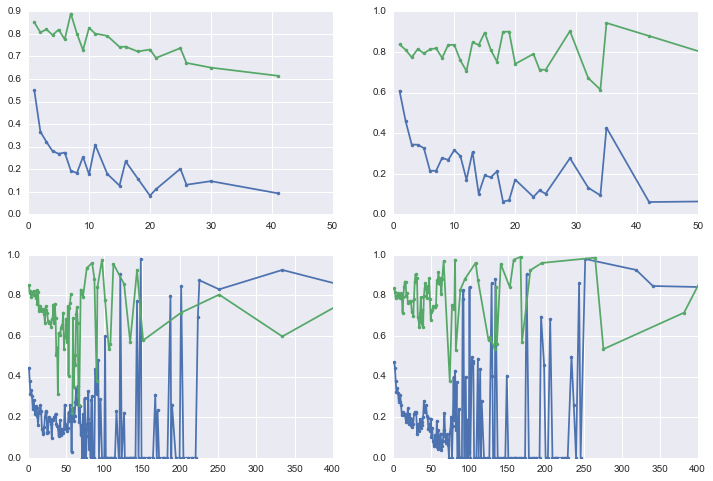

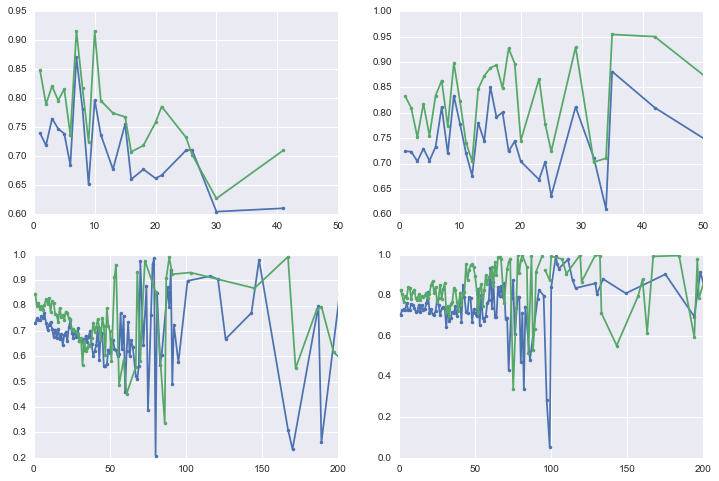

In [820]:
# jump distance as a function of value (by listen)
fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.flat
ax = axes.next()
df_raw.groupby(np.digitize(df_raw['final_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
df_raw_rand.groupby(np.digitize(df_raw_rand['final_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
df_raw.groupby(np.digitize(df_raw['final_value_tfidf'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
df_raw_rand.groupby(np.digitize(df_raw_rand['final_value_tfidf'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
df_raw.groupby(np.digitize(df_raw['current_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
df_raw_rand.groupby(np.digitize(df_raw_rand['current_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,400)
ax = axes.next()
df_raw.groupby(np.digitize(df_raw['current_value_tfidf'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
df_raw_rand.groupby(np.digitize(df_raw_rand['current_value_tfidf'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,400)

fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.flat
ax = axes.next()
blocked.groupby(np.digitize(blocked['final_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
blocked_rand.groupby(np.digitize(blocked_rand['final_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
blocked.groupby(np.digitize(blocked['final_value_tfidf'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
blocked_rand.groupby(np.digitize(blocked_rand['final_value_tfidf'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
blocked.groupby(np.digitize(blocked['current_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
blocked_rand.groupby(np.digitize(blocked_rand['current_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,200)
ax = axes.next()
blocked.groupby(np.digitize(blocked['current_value_tfidf'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
blocked_rand.groupby(np.digitize(blocked_rand['current_value_tfidf'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,200)

(0, 200)

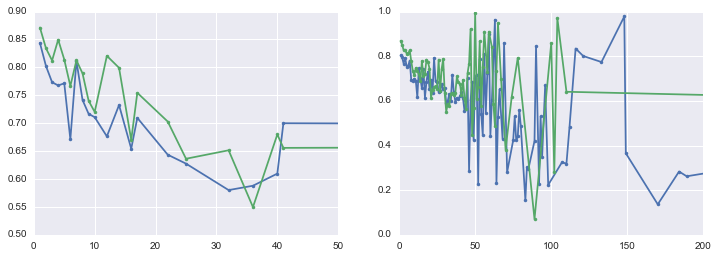

In [821]:
# jump distance as a function of value (by patch)

fig,axes = plt.subplots(1,2,figsize=(12,4))
axes = axes.flat
ax = axes.next()
df_patches.groupby(np.digitize(df_patches['final_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
df_patches_rand.groupby(np.digitize(df_patches_rand['final_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
df_patches.groupby(np.digitize(df_patches['current_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
df_patches_rand.groupby(np.digitize(df_patches_rand['current_value'],bins=bins))['nextdist'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,200)


In [831]:
def return_time_listens(df):
    df['return_time'] = df['overall_index'].shift(-1)-df['overall_index']
    return df[['return_time']]

def return_time(df):
    df['return_time'] = df['overall_index'].shift(-1) - (df['overall_index']+df['n']-1)
    return df[['return_time']]

rt = df_raw.groupby('artist_idx').apply(return_time_listens)
df_raw['return_time'] = rt

rt = df_raw_rand.groupby('artist_idx').apply(return_time_listens)
df_raw_rand['return_time'] = rt

rt = blocked.groupby('artist_idx').apply(return_time)
blocked['return_time'] = rt

rt = blocked_rand.groupby('artist_idx').apply(return_time)
blocked_rand['return_time'] = rt

rt = df_patches.groupby('patch_clust').apply(return_time)
df_patches['return_time'] = rt

rt = df_patches_rand.groupby('patch_clust').apply(return_time)
df_patches_rand['return_time'] = rt

(0, 400)

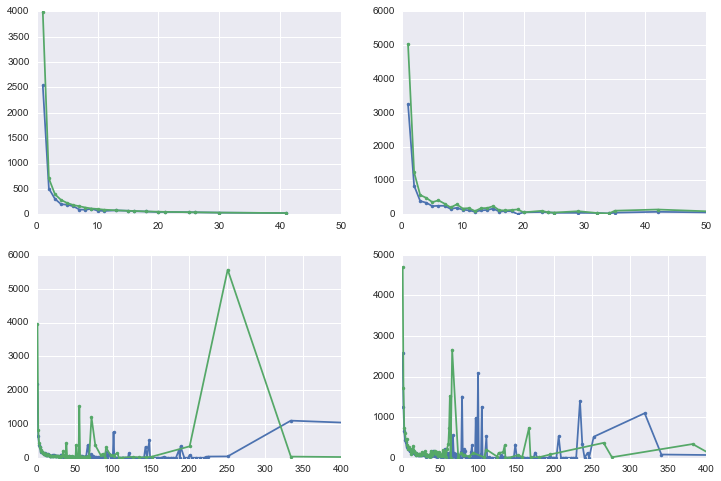

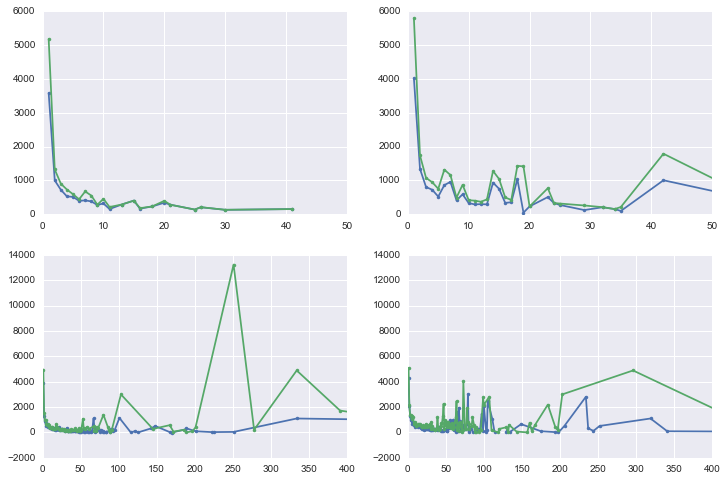

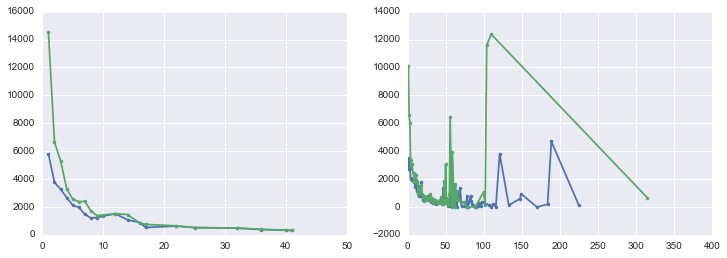

In [832]:
# return time  as a function of value (by listen)
fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.flat
ax = axes.next()
df_raw.groupby(np.digitize(df_raw['final_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
df_raw_rand.groupby(np.digitize(df_raw_rand['final_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
df_raw.groupby(np.digitize(df_raw['final_value_tfidf'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
df_raw_rand.groupby(np.digitize(df_raw_rand['final_value_tfidf'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
df_raw.groupby(np.digitize(df_raw['current_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
df_raw_rand.groupby(np.digitize(df_raw_rand['current_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,400)
ax = axes.next()
df_raw.groupby(np.digitize(df_raw['current_value_tfidf'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
df_raw_rand.groupby(np.digitize(df_raw_rand['current_value_tfidf'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,400)

# return time as a function of value (by block)
fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.flat
ax = axes.next()
blocked.groupby(np.digitize(blocked['final_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
blocked_rand.groupby(np.digitize(blocked_rand['final_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
blocked.groupby(np.digitize(blocked['final_value_tfidf'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
blocked_rand.groupby(np.digitize(blocked_rand['final_value_tfidf'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
blocked.groupby(np.digitize(blocked['current_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
blocked_rand.groupby(np.digitize(blocked_rand['current_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,400)
ax = axes.next()
blocked.groupby(np.digitize(blocked['current_value_tfidf'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
blocked_rand.groupby(np.digitize(blocked_rand['current_value_tfidf'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,400)

# return time  as a function of value (by patch)
fig,axes = plt.subplots(1,2,figsize=(12,4))
axes = axes.flat
ax = axes.next()
df_patches.groupby(np.digitize(df_patches['final_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
df_patches_rand.groupby(np.digitize(df_patches_rand['final_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,50)
ax = axes.next()
df_patches.groupby(np.digitize(df_patches['current_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
df_patches_rand.groupby(np.digitize(df_patches_rand['current_value'],bins=bins))['return_time'].mean().plot(ax=ax,marker='.')
ax.set_xlim(0,400)


# scratch

(0, 50)

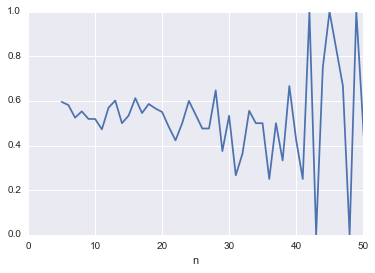

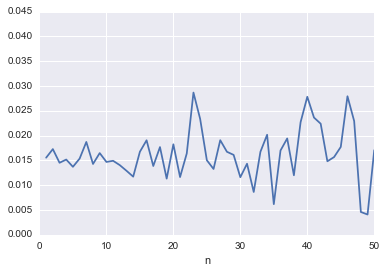

In [911]:
#df_patches['explore'] = df_patches['patch_clust'].apply(lambda x: int(np.isnan(x)))
#df_patches['explore-next'] = df_patches['explore'].shift(-1)
df_patches['exploit-next'] = 1-df_patches['explore-next']
fig,ax = plt.subplots()
df_patches[~np.isnan(df_patches['patch_clust'])].groupby('n')['explore-next'].mean().plot(ax=ax)
ax.set_xlim(0,50)
fig,ax = plt.subplots()
df_patches['value-next'] = df_patches['final_value'].shift(-1)
df_patches[np.isnan(df_patches['patch_clust'])].groupby('n')['value-next'].mean().plot(ax=ax)
ax.set_xlim(0,50)

In [910]:
def grouper(df):
    df['n_total'] = df['n'].cumsum()
df_patches.groupby('explore').apply()
df_patches['n_exploit']
df_patches.groupby()

,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit,next,nextdist,return_time,explore,explore-next,exploit-next
0,"[0.00220395499965, 0.00644255506066, 0.0079506...",0.730417,69,2007-02-24 22:54:28,NaN,NaN,NaN,NaN,69,NaN,0,NaN,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.427401,NaN,1,0.0,1.0
1,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.000000,16,2007-02-26 07:07:20,91.0,0.024017,0.040019,16.0,85,0.188235,16,1.000000,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.262133,4690.0,0,0.0,1.0
2,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.000000,13,2007-02-26 09:01:11,53.0,0.008550,0.014246,13.0,98,0.132653,29,0.448276,"[0.00053988837863, 0.00230712601993, 0.0017630...",0.774041,123.0,0,1.0,0.0
3,"[0.00053988837863, 0.00230712601993, 0.0017630...",0.718714,12,2007-02-26 20:55:48,NaN,NaN,NaN,NaN,110,NaN,29,NaN,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.375220,NaN,1,0.0,1.0
4,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.000000,8,2007-02-27 04:25:49,90.0,0.015009,0.025008,8.0,118,0.067797,37,0.216216,"[0.00274972236358, 0.000955550863693, 0.003491...",0.430958,570.0,0,0.0,1.0
5,"[0.00274972236358, 0.000955550863693, 0.003491...",0.000000,24,2007-02-27 05:19:15,128.0,0.021553,0.035913,24.0,142,0.169014,61,0.393443,"[0.0019293407964, 0.0155826688396, 0.000162418...",0.136510,-9.0,0,1.0,0.0
6,"[0.0019293407964, 0.0155826688396, 0.000162418...",0.170463,3,2007-02-27 18:58:54,NaN,NaN,NaN,NaN,145,NaN,61,NaN,"[0.00274972236358, 0.000955550863693, 0.003491...",0.136510,NaN,1,0.0,1.0
7,"[0.00274972236358, 0.000955550863693, 0.003491...",0.000000,11,2007-02-28 01:51:39,128.0,0.021553,0.035913,35.0,156,0.224359,72,0.486111,"[0.00223568466209, 0.00759385656061, 0.0094159...",0.302091,129.0,0,1.0,0.0
8,"[0.00223568466209, 0.00759385656061, 0.0094159...",0.686098,63,2007-02-28 03:07:59,NaN,NaN,NaN,NaN,219,NaN,72,NaN,"[2.19839174458e-07, 0.0184632976208, 2.1983917...",0.666288,NaN,1,0.0,1.0
9,"[2.19839174458e-07, 0.0184632976208, 2.1983917...",0.012615,14,2007-03-02 04:17:48,53.0,0.008550,0.014246,27.0,233,0.115880,86,0.313953,"[0.000695031556674, 0.0270267914413, 1.6291796...",0.834669,-2.0,0,1.0,0.0
